In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchaudio
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ASTForAudioClassification, AutoProcessor
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import json
from datetime import datetime


In [2]:
Ravdess = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/"
Crema   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/"
Tess    = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/"
Savee   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/"

In [ ]:
ravdess_directory_list = [d for d in os.listdir(Ravdess) if d.startswith("Actor_")]

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_folder = os.path.join(Ravdess, dir)
    
    for file in os.listdir(actor_folder):
        if not file.endswith('.wav'):
            continue  
        
        part = file.split('.')[0].split('-')
        
        if len(part) != 7:
            print(f"⚠️ Skipping malformed file: {file}")
            continue
        
        try:
            emotion_code = int(part[2])
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_folder, file))
        except ValueError:
            print(f"❌ Couldn't parse emotion code in: {file}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)


emotion_labels = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
Ravdess_df["Emotions"] = Ravdess_df["Emotions"].map(emotion_labels)

print(Ravdess_df.head())
print(Ravdess_df["Path"].values[1])

  Emotions                                               Path
0  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4     calm  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/Actor_01/03-01-01-01-01-02-01.wav


In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:

    file_path.append(Crema + file)

    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/1001_DFA_DIS_XX.wav


In [ ]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + "/"+dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df['Path'].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/DC_a02.wav


In [7]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path
0,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4,calm,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
...,...,...
475,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
476,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
477,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
478,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...


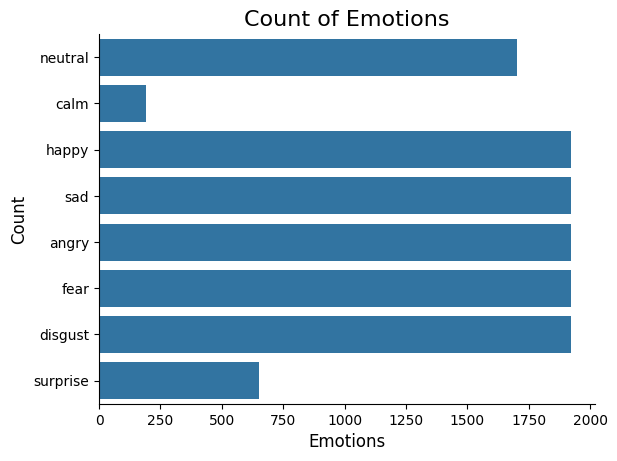

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:

def volume_perturbation(data, low=0.5, high=1.5):
    factor = np.random.uniform(low, high)
    return data * factor

def clipping_distortion(data, clip_percent=0.02):
    threshold = clip_percent * np.max(np.abs(data))
    data = np.clip(data, -threshold, threshold)
    return data

def pink_noise(data):

    uneven = data.shape[0] % 2
    X = np.random.randn(data.shape[0]//2 + 1 + uneven) + 1j * np.random.randn(data.shape[0]//2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)  
    y = (np.fft.irfft(X / S)).real
    if uneven:
        y = y[:-1]
    y = y / np.max(np.abs(y)) 
    return data + 0.005 * y

def salt_and_pepper_audio(data, amount=0.005):
    noisy_data = data.copy()
    num_samples = int(amount * data.shape[0])
    indices = np.random.randint(0, data.shape[0], num_samples)
    for i in indices:
        noisy_data[i] = np.random.choice([np.min(data), np.max(data)])
    return noisy_data

def add_noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=steps)


# ========== Dataset ==========
class EmotionAudioDataset(Dataset):
    def __init__(self, dataframe, processor_name="MIT/ast-finetuned-speech-commands-v2", train=True):
        df = dataframe.copy().dropna().reset_index(drop=True)

        # Encode emotions to integers
        self.label_map = {emotion: i for i, emotion in enumerate(sorted(df["Emotions"].unique()))}
        self.df = df.copy()
        self.df["label"] = self.df["Emotions"].map(self.label_map)
        
        # Stratified split
        train_df, val_df = train_test_split(self.df, test_size=0.2, stratify=self.df["label"], random_state=42)

        
        self.df = train_df if train else val_df
             # Step 2: Augment training set
        augmented_rows_train = []
        for _, row in self.df.iterrows():
            for aug_type in ["original", "noise", "stretch_pitch", "salt_pepper", "pink", "clip", "volume"]:
                augmented_rows_train.append({
                    "Path": row["Path"],
                    "Emotions": row["Emotions"],
                    "label": row["label"],  # <-- ЭТО ВАЖНО
                    "AugType": aug_type
                })
        self.df = pd.DataFrame(augmented_rows_train)

        self.processor = AutoProcessor.from_pretrained(processor_name)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row["Path"]
        label = row["label"]
        aug_type = row["AugType"]

        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"❌ Error loading {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)
        
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0)
        waveform = waveform.squeeze().numpy()

        # Apply augmentation
        if aug_type == "noise":
            waveform = add_noise(waveform)
        elif aug_type == "stretch_pitch":
            waveform = stretch(waveform)
            waveform = pitch(waveform, sample_rate)
        elif aug_type == "salt_pepper":
            waveform = salt_and_pepper_audio(waveform)
        elif aug_type == "pink":
            waveform = pink_noise(waveform)
        elif aug_type == "clip":
            waveform = clipping_distortion(waveform)
        elif aug_type == "volume":
            waveform = volume_perturbation(waveform)

        # Resample if needed
        if sample_rate != 16000:
            waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)
            sample_rate = 16000

        # Back to tensor
        waveform = torch.tensor(waveform)

        try:
            processed = self.processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt",
                padding="max_length",
                max_length=16000
            )
            input_values = processed.input_values.squeeze(0)
        except Exception as e:
            print(f"❌ Error processing {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)

        return input_values, torch.tensor(label)

# ========== Classifier ==========
class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)
    

class ComplexClassifierHead(nn.Module):
    def __init__(self, input_dim=768, num_classes=8):
        super().__init__()
        self.norm = nn.LayerNorm(input_dim)

        self.fc1 = nn.Linear(input_dim, 512)
        self.act1 = nn.GELU()
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 512)
        self.act2 = nn.GELU()
        self.drop2 = nn.Dropout(0.3)

        self.res_fc = nn.Linear(input_dim, 512)  # for residual connection

        self.output = nn.Linear(512, num_classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x = [B, D] where D=768
        x = self.norm(x)

        res = self.res_fc(x)  # residual path

        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))

        x = x + res  # add residual

        return self.softmax(self.output(x))


def save_checkpoint(model, optimizer, epoch, path="checkpoints/checkpoint.pth"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"\u2705 Checkpoint saved at epoch {epoch}")

# ========== Training ==========
def train_model(model, train_loader, val_loader, label_map, num_epochs=10, learning_rate=2e-5, checkpoint_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate)

    train_labels = train_loader.dataset.df["label"]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # log for saving full metrics
    metrics_log = []

    start_epoch = 0

    ast_unfrozen = False
    if checkpoint_path and os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

    for epoch in range(start_epoch, num_epochs):

        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # === Unfreeze AST backbone after epoch 15 ===
        if epoch == 5 and not ast_unfrozen:
            print("🔓 Unfreezing AST backbone...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
            ast_unfrozen = True

        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(input_values=inputs).logits

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                val_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Get full classification report
        target_names = list(label_map.keys())
        report = classification_report(
            all_labels, all_preds,
            target_names=target_names,
            digits=4,
            output_dict=True
        )

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print(f"F1 Score: {f1_weighted:.4f}")
        print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

        save_checkpoint(model, optimizer, epoch + 1, path=f"checkpoints/epoch_{epoch+1}.pth")

        # Flatten the classification report
        flat_report = {
            f"{label}_{metric}": round(value, 4)
            for label, scores in report.items()
            for metric, value in (scores.items() if isinstance(scores, dict) else [("value", scores)])
        }

        # Save all metrics
        epoch_metrics = {
            "epoch": epoch + 1,
            "timestamp": datetime.now().isoformat(),
            "train_loss": round(train_loss, 4),
            "train_accuracy": round(train_acc, 2),
            "val_loss": round(val_loss, 4),
            "val_accuracy": round(val_acc, 2),
            "f1_weighted": round(f1_weighted, 4),
            "f1_macro": round(f1_macro, 4),
            "report": flat_report
        }

        metrics_log.append(epoch_metrics)
        with open("metrics_log.json", "w") as f:
            json.dump(metrics_log, f, indent=2)

    print("\u2705 Training complete!")

    # Plot and save curves
    total_epochs_ran = range(start_epoch + 1, start_epoch + len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs_ran, train_losses, label='Train Loss')
    plt.plot(total_epochs_ran, val_losses, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(total_epochs_ran, train_accs, label='Train Acc')
    plt.plot(total_epochs_ran, val_accs, label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()


def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"\u2705 Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']

# ========== Main ==========
if __name__ == "__main__":



    train_dataset = EmotionAudioDataset(data_path, train=True)
    val_dataset = EmotionAudioDataset(data_path, train=False)


    

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-speech-commands-v2",
        num_labels=len(train_dataset.label_map),
        ignore_mismatched_sizes=True
    )

    for param in model.parameters():
        param.requires_grad = False

    # custom_clf = CustomClassifier(model.config.hidden_size, len(train_dataset.label_map))
    # model.classifier = custom_clf

    custom_clf = ComplexClassifierHead(model.config.hidden_size, len(train_dataset.label_map))
    model.classifier = custom_clf

    for param in model.classifier.parameters():
        param.requires_grad = True

    train_model(
    model,
    train_loader,
    val_loader,
    label_map=train_dataset.label_map,
    num_epochs=75, 
    checkpoint_path="checkpoints/epoch_52.pth"
    )

    torch.save(model.state_dict(), "final_model_emotions_with_augmentation_state_dict.pth")
    torch.save(model, "final_model_emotions_with_augmentation.pth")

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-speech-commands-v2 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([35]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([35, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/75

Epoch 1/75


Epoch 1, Loss: 1.8948, Accuracy: 30.28%


Validation Loss: 1.8552, Accuracy: 39.56%
F1 Score: 0.3728
              precision    recall  f1-score   support

       angry     0.4508    0.5469    0.4942      2695
        calm     0.1804    0.9474    0.3031       266
     disgust     0.8624    0.0954    0.1717      2695
        fear     0.4348    0.3525    0.3893      2695
       happy     0.3640    0.2156    0.2708      2695
     neutral     0.4074    0.4521    0.4286      2380
         sad     0.3557    0.5573    0.4342      2695
    surprise     0.4546    0.7099    0.5543       910

    accuracy                         0.3956     17031
   macro avg     0.4388    0.4846    0.3808     17031
weighted avg     0.4745    0.3956    0.3728     17031

✅ Checkpoint saved at epoch 1

Epoch 2/75

Epoch 2/75


Epoch 2, Loss: 1.7899, Accuracy: 42.09%


Validation Loss: 1.8032, Accuracy: 44.03%
F1 Score: 0.4263
              precision    recall  f1-score   support

       angry     0.5381    0.6256    0.5786      2695
        calm     0.1781    0.9887    0.3018       266
     disgust     0.6442    0.1848    0.2872      2695
        fear     0.5021    0.3169    0.3885      2695
       happy     0.3872    0.2701    0.3183      2695
     neutral     0.4266    0.5458    0.4789      2380
         sad     0.4305    0.5399    0.4790      2695
    surprise     0.4361    0.7868    0.5611       910

    accuracy                         0.4403     17031
   macro avg     0.4429    0.5323    0.4242     17031
weighted avg     0.4816    0.4403    0.4263     17031

✅ Checkpoint saved at epoch 2

Epoch 3/75

Epoch 3/75


Epoch 3, Loss: 1.7526, Accuracy: 45.71%


Validation Loss: 1.7804, Accuracy: 46.32%
F1 Score: 0.4429
              precision    recall  f1-score   support

       angry     0.5326    0.7087    0.6082      2695
        calm     0.2108    0.9699    0.3463       266
     disgust     0.5629    0.2275    0.3240      2695
        fear     0.5717    0.2694    0.3662      2695
       happy     0.4220    0.2508    0.3146      2695
     neutral     0.4665    0.5853    0.5192      2380
         sad     0.4292    0.5870    0.4958      2695
    surprise     0.4603    0.8033    0.5853       910

    accuracy                         0.4632     17031
   macro avg     0.4570    0.5502    0.4450     17031
weighted avg     0.4916    0.4632    0.4429     17031

✅ Checkpoint saved at epoch 3

Epoch 4/75

Epoch 4/75


Epoch 4, Loss: 1.7326, Accuracy: 47.80%


Validation Loss: 1.7679, Accuracy: 47.21%
F1 Score: 0.4580
              precision    recall  f1-score   support

       angry     0.5956    0.6772    0.6338      2695
        calm     0.2166    0.9812    0.3549       266
     disgust     0.5694    0.2330    0.3307      2695
        fear     0.5073    0.3210    0.3932      2695
       happy     0.4076    0.2946    0.3420      2695
     neutral     0.4502    0.6550    0.5336      2380
         sad     0.5067    0.5035    0.5051      2695
    surprise     0.4032    0.8264    0.5420       910

    accuracy                         0.4721     17031
   macro avg     0.4571    0.5615    0.4544     17031
weighted avg     0.4972    0.4721    0.4580     17031

✅ Checkpoint saved at epoch 4

Epoch 5/75

Epoch 5/75


Epoch 5, Loss: 1.7173, Accuracy: 49.27%


Validation Loss: 1.7558, Accuracy: 48.10%
F1 Score: 0.4612
              precision    recall  f1-score   support

       angry     0.5454    0.7488    0.6311      2695
        calm     0.2366    0.9624    0.3798       266
     disgust     0.5566    0.2571    0.3518      2695
        fear     0.5146    0.3147    0.3905      2695
       happy     0.4357    0.2401    0.3096      2695
     neutral     0.5062    0.5878    0.5439      2380
         sad     0.4794    0.5833    0.5263      2695
    surprise     0.4152    0.8341    0.5544       910

    accuracy                         0.4810     17031
   macro avg     0.4612    0.5660    0.4609     17031
weighted avg     0.4972    0.4810    0.4612     17031

✅ Checkpoint saved at epoch 5

Epoch 6/75
🔓 Unfreezing AST backbone...

Epoch 6/75


Epoch 6, Loss: 1.6240, Accuracy: 59.09%


Validation Loss: 1.6571, Accuracy: 58.58%
F1 Score: 0.5875
              precision    recall  f1-score   support

       angry     0.7260    0.7336    0.7298      2695
        calm     0.2387    0.9737    0.3834       266
     disgust     0.5629    0.4835    0.5202      2695
        fear     0.5933    0.5109    0.5490      2695
       happy     0.5304    0.4438    0.4832      2695
     neutral     0.6490    0.6424    0.6457      2380
         sad     0.5971    0.6093    0.6031      2695
    surprise     0.5661    0.7626    0.6498       910

    accuracy                         0.5858     17031
   macro avg     0.5579    0.6450    0.5705     17031
weighted avg     0.6009    0.5858    0.5875     17031

✅ Checkpoint saved at epoch 6

Epoch 7/75

Epoch 7/75


Epoch 7, Loss: 1.5234, Accuracy: 71.05%


Validation Loss: 1.6370, Accuracy: 60.77%
F1 Score: 0.6061
              precision    recall  f1-score   support

       angry     0.6775    0.7911    0.7299      2695
        calm     0.2989    0.9248    0.4518       266
     disgust     0.6440    0.4638    0.5393      2695
        fear     0.5265    0.5796    0.5517      2695
       happy     0.6333    0.4935    0.5547      2695
     neutral     0.6836    0.6055    0.6422      2380
         sad     0.5771    0.6071    0.5917      2695
    surprise     0.6775    0.8264    0.7446       910

    accuracy                         0.6077     17031
   macro avg     0.5898    0.6615    0.6007     17031
weighted avg     0.6203    0.6077    0.6061     17031

✅ Checkpoint saved at epoch 7

Epoch 8/75

Epoch 8/75


Epoch 8, Loss: 1.4650, Accuracy: 77.75%


Validation Loss: 1.6259, Accuracy: 61.78%
F1 Score: 0.6188
              precision    recall  f1-score   support

       angry     0.7623    0.7139    0.7373      2695
        calm     0.3029    0.9474    0.4590       266
     disgust     0.5807    0.5232    0.5505      2695
        fear     0.5895    0.5009    0.5416      2695
       happy     0.6264    0.5644    0.5938      2695
     neutral     0.6754    0.6391    0.6567      2380
         sad     0.5668    0.6631    0.6111      2695
    surprise     0.6726    0.8308    0.7434       910

    accuracy                         0.6178     17031
   macro avg     0.5971    0.6728    0.6117     17031
weighted avg     0.6297    0.6178    0.6188     17031

✅ Checkpoint saved at epoch 8

Epoch 9/75

Epoch 9/75


Epoch 9, Loss: 1.4359, Accuracy: 81.21%


Validation Loss: 1.6270, Accuracy: 61.89%
F1 Score: 0.6140
              precision    recall  f1-score   support

       angry     0.7059    0.7803    0.7413      2695
        calm     0.3026    0.9248    0.4560       266
     disgust     0.5908    0.5154    0.5505      2695
        fear     0.7176    0.3763    0.4937      2695
       happy     0.6501    0.5688    0.6068      2695
     neutral     0.6270    0.6920    0.6579      2380
         sad     0.5498    0.6820    0.6088      2695
    surprise     0.6722    0.8473    0.7496       910

    accuracy                         0.6189     17031
   macro avg     0.6020    0.6734    0.6081     17031
weighted avg     0.6369    0.6189    0.6140     17031

✅ Checkpoint saved at epoch 9

Epoch 10/75

Epoch 10/75


Epoch 10, Loss: 1.4170, Accuracy: 83.43%


Validation Loss: 1.6272, Accuracy: 61.85%
F1 Score: 0.6181
              precision    recall  f1-score   support

       angry     0.7741    0.7121    0.7418      2695
        calm     0.3177    0.9436    0.4754       266
     disgust     0.5458    0.5510    0.5484      2695
        fear     0.6561    0.4078    0.5030      2695
       happy     0.6198    0.6193    0.6195      2695
     neutral     0.6951    0.6408    0.6668      2380
         sad     0.5351    0.6783    0.5983      2695
    surprise     0.7131    0.8330    0.7684       910

    accuracy                         0.6185     17031
   macro avg     0.6071    0.6732    0.6152     17031
weighted avg     0.6356    0.6185    0.6181     17031

✅ Checkpoint saved at epoch 10

Epoch 11/75

Epoch 11/75


Epoch 11, Loss: 1.4026, Accuracy: 85.17%


Validation Loss: 1.6258, Accuracy: 62.16%
F1 Score: 0.6217
              precision    recall  f1-score   support

       angry     0.7852    0.7054    0.7432      2695
        calm     0.3261    0.9023    0.4790       266
     disgust     0.6012    0.4950    0.5429      2695
        fear     0.6071    0.5058    0.5518      2695
       happy     0.5844    0.6330    0.6078      2695
     neutral     0.6108    0.7109    0.6571      2380
         sad     0.5933    0.5937    0.5935      2695
    surprise     0.7324    0.8242    0.7756       910

    accuracy                         0.6216     17031
   macro avg     0.6051    0.6713    0.6189     17031
weighted avg     0.6314    0.6216    0.6217     17031

✅ Checkpoint saved at epoch 11

Epoch 12/75

Epoch 12/75


Epoch 12, Loss: 1.3922, Accuracy: 86.38%


Validation Loss: 1.6225, Accuracy: 62.64%
F1 Score: 0.6217
              precision    recall  f1-score   support

       angry     0.6859    0.7818    0.7307      2695
        calm     0.3398    0.9286    0.4975       266
     disgust     0.6334    0.5128    0.5667      2695
        fear     0.6488    0.4134    0.5050      2695
       happy     0.6098    0.6100    0.6099      2695
     neutral     0.6049    0.7508    0.6700      2380
         sad     0.6086    0.6163    0.6125      2695
    surprise     0.7610    0.7978    0.7790       910

    accuracy                         0.6264     17031
   macro avg     0.6115    0.6764    0.6214     17031
weighted avg     0.6347    0.6264    0.6217     17031

✅ Checkpoint saved at epoch 12

Epoch 13/75

Epoch 13/75


Epoch 13, Loss: 1.3827, Accuracy: 87.47%


Validation Loss: 1.6133, Accuracy: 63.34%
F1 Score: 0.6340
              precision    recall  f1-score   support

       angry     0.7322    0.7729    0.7520      2695
        calm     0.3143    0.9511    0.4725       266
     disgust     0.6174    0.5180    0.5634      2695
        fear     0.5579    0.5525    0.5552      2695
       happy     0.6903    0.5466    0.6101      2695
     neutral     0.6943    0.6748    0.6844      2380
         sad     0.5791    0.6453    0.6104      2695
    surprise     0.7483    0.8231    0.7839       910

    accuracy                         0.6334     17031
   macro avg     0.6167    0.6855    0.6290     17031
weighted avg     0.6446    0.6334    0.6340     17031

✅ Checkpoint saved at epoch 13

Epoch 14/75

Epoch 14/75


Epoch 14, Loss: 1.3773, Accuracy: 88.16%


Validation Loss: 1.6184, Accuracy: 63.20%
F1 Score: 0.6311
              precision    recall  f1-score   support

       angry     0.7203    0.7770    0.7476      2695
        calm     0.2869    0.8985    0.4349       266
     disgust     0.5644    0.5640    0.5642      2695
        fear     0.6624    0.4638    0.5456      2695
       happy     0.6773    0.5607    0.6135      2695
     neutral     0.6421    0.7403    0.6877      2380
         sad     0.6089    0.6067    0.6078      2695
    surprise     0.7165    0.8275    0.7680       910

    accuracy                         0.6320     17031
   macro avg     0.6099    0.6798    0.6212     17031
weighted avg     0.6442    0.6320    0.6311     17031

✅ Checkpoint saved at epoch 14

Epoch 15/75

Epoch 15/75


Epoch 15, Loss: 1.3698, Accuracy: 88.97%


Validation Loss: 1.6161, Accuracy: 63.82%
F1 Score: 0.6375
              precision    recall  f1-score   support

       angry     0.7285    0.7826    0.7546      2695
        calm     0.3555    0.8459    0.5006       266
     disgust     0.6151    0.5195    0.5633      2695
        fear     0.5632    0.5737    0.5684      2695
       happy     0.7221    0.5514    0.6253      2695
     neutral     0.6448    0.7391    0.6887      2380
         sad     0.5885    0.6059    0.5971      2695
    surprise     0.7720    0.7813    0.7766       910

    accuracy                         0.6382     17031
   macro avg     0.6237    0.6749    0.6343     17031
weighted avg     0.6460    0.6382    0.6375     17031

✅ Checkpoint saved at epoch 15

Epoch 16/75

Epoch 16/75


Epoch 16, Loss: 1.3654, Accuracy: 89.54%


Validation Loss: 1.6216, Accuracy: 63.40%
F1 Score: 0.6346
              precision    recall  f1-score   support

       angry     0.7736    0.6909    0.7299      2695
        calm     0.3800    0.7556    0.5057       266
     disgust     0.5913    0.5685    0.5796      2695
        fear     0.5954    0.5046    0.5463      2695
       happy     0.5877    0.6712    0.6267      2695
     neutral     0.6958    0.6630    0.6790      2380
         sad     0.5919    0.6360    0.6131      2695
    surprise     0.7577    0.8143    0.7850       910

    accuracy                         0.6340     17031
   macro avg     0.6217    0.6630    0.6332     17031
weighted avg     0.6405    0.6340    0.6346     17031

✅ Checkpoint saved at epoch 16

Epoch 17/75

Epoch 17/75


Epoch 17, Loss: 1.3600, Accuracy: 90.16%


Validation Loss: 1.6243, Accuracy: 63.01%
F1 Score: 0.6288
              precision    recall  f1-score   support

       angry     0.6998    0.7603    0.7288      2695
        calm     0.3559    0.8496    0.5017       266
     disgust     0.6099    0.5250    0.5643      2695
        fear     0.5943    0.4887    0.5363      2695
       happy     0.6154    0.6122    0.6138      2695
     neutral     0.6619    0.7050    0.6828      2380
         sad     0.5942    0.6271    0.6102      2695
    surprise     0.8108    0.7769    0.7935       910

    accuracy                         0.6301     17031
   macro avg     0.6178    0.6681    0.6289     17031
weighted avg     0.6341    0.6301    0.6288     17031

✅ Checkpoint saved at epoch 17

Epoch 18/75

Epoch 18/75


Epoch 18, Loss: 1.3558, Accuracy: 90.60%


Validation Loss: 1.6231, Accuracy: 63.04%
F1 Score: 0.6285
              precision    recall  f1-score   support

       angry     0.7143    0.7599    0.7364      2695
        calm     0.4040    0.7519    0.5256       266
     disgust     0.5651    0.5588    0.5619      2695
        fear     0.5984    0.5065    0.5486      2695
       happy     0.6248    0.6141    0.6194      2695
     neutral     0.6823    0.6903    0.6863      2380
         sad     0.6111    0.5744    0.5922      2695
    surprise     0.6814    0.8484    0.7558       910

    accuracy                         0.6304     17031
   macro avg     0.6102    0.6630    0.6283     17031
weighted avg     0.6308    0.6304    0.6285     17031

✅ Checkpoint saved at epoch 18

Epoch 19/75

Epoch 19/75


Epoch 19, Loss: 1.3522, Accuracy: 91.00%


Validation Loss: 1.6325, Accuracy: 62.11%
F1 Score: 0.6183
              precision    recall  f1-score   support

       angry     0.6579    0.7907    0.7182      2695
        calm     0.3724    0.7519    0.4981       266
     disgust     0.6225    0.5250    0.5696      2695
        fear     0.5784    0.5199    0.5476      2695
       happy     0.6021    0.5896    0.5958      2695
     neutral     0.6639    0.6655    0.6647      2380
         sad     0.6261    0.5592    0.5907      2695
    surprise     0.6658    0.8253    0.7370       910

    accuracy                         0.6211     17031
   macro avg     0.5986    0.6534    0.6152     17031
weighted avg     0.6227    0.6211    0.6183     17031

✅ Checkpoint saved at epoch 19

Epoch 20/75

Epoch 20/75


Epoch 20, Loss: 1.3505, Accuracy: 91.31%


Validation Loss: 1.6337, Accuracy: 62.56%
F1 Score: 0.6248
              precision    recall  f1-score   support

       angry     0.7041    0.7629    0.7323      2695
        calm     0.3975    0.7143    0.5108       266
     disgust     0.5926    0.5321    0.5607      2695
        fear     0.5912    0.5161    0.5511      2695
       happy     0.5868    0.5892    0.5880      2695
     neutral     0.6548    0.7055    0.6792      2380
         sad     0.5875    0.6119    0.5994      2695
    surprise     0.8531    0.7341    0.7891       910

    accuracy                         0.6256     17031
   macro avg     0.6209    0.6458    0.6263     17031
weighted avg     0.6279    0.6256    0.6248     17031

✅ Checkpoint saved at epoch 20

Epoch 21/75

Epoch 21/75


Epoch 21, Loss: 1.3466, Accuracy: 91.70%


Validation Loss: 1.6260, Accuracy: 62.87%
F1 Score: 0.6276
              precision    recall  f1-score   support

       angry     0.7466    0.7432    0.7449      2695
        calm     0.3660    0.8008    0.5024       266
     disgust     0.5388    0.6137    0.5738      2695
        fear     0.6055    0.4612    0.5236      2695
       happy     0.6902    0.5506    0.6126      2695
     neutral     0.6340    0.7315    0.6793      2380
         sad     0.5869    0.6067    0.5966      2695
    surprise     0.7638    0.8066    0.7846       910

    accuracy                         0.6287     17031
   macro avg     0.6165    0.6643    0.6272     17031
weighted avg     0.6364    0.6287    0.6276     17031

✅ Checkpoint saved at epoch 21

Epoch 22/75

Epoch 22/75


Epoch 22, Loss: 1.3455, Accuracy: 91.88%


Validation Loss: 1.6223, Accuracy: 63.48%
F1 Score: 0.6340
              precision    recall  f1-score   support

       angry     0.7701    0.7009    0.7339      2695
        calm     0.3735    0.7105    0.4896       266
     disgust     0.6151    0.5573    0.5848      2695
        fear     0.6129    0.4994    0.5504      2695
       happy     0.5623    0.6887    0.6191      2695
     neutral     0.6400    0.7298    0.6820      2380
         sad     0.6433    0.5729    0.6061      2695
    surprise     0.7341    0.8220    0.7755       910

    accuracy                         0.6348     17031
   macro avg     0.6189    0.6602    0.6302     17031
weighted avg     0.6414    0.6348    0.6340     17031

✅ Checkpoint saved at epoch 22

Epoch 23/75

Epoch 23/75


KeyboardInterrupt: 